# Проект для «Викишоп»

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

## Цель исследованния

Создать модель для классификация комментаии на позитивные и негативные. У нас, набор данных с разметкой о токсичности правок.

## Ходь исследованния

- Сначала мы собираемся загрузить и изучить наши наборы данных.
- Во-вторых, мы создали функцию для подготовки ваших комментариев для использования модуля TfidfVectorizer
- В-третьих, с помошю кросс-валидации выберем лучшие модел по метрику F1. 

In [1]:
# Установление модулов

!pip install -q wordcloud
!pip install -q --upgrade pillow

In [2]:
#Загружка бтбдиотеки

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели для classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

# Подготовка

## Загрузка данных

In [3]:
# Загружаем датафреймы
df = pd.read_csv('/datasets/toxic_comments.csv', usecols=['text', 'toxic'])

In [4]:
pd.set_option('display.max_colwidth', None)
df.head(5)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [5]:
# Копирование исходных датафреймы
df_rgn = df.copy()

## Изучение датафреймы

In [6]:
# Изучение датафреймы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
# Проверка дубликаов
df['text'].duplicated().sum()

0

Датафрейм состоит из 159292 объектов и содержит 2 столбца:
- 'text', все комментарии из Википедии
- 'toxic', наша целевая переменная

Нет пропущенных значений и нет дубликатов.

# Splitting the data

Давайте сейчас разделим данные, а позже воспользуемся трансформаторами для работы с признаком «текст».

In [8]:
# Констант случайное состояние
RANDOM_STATE = 42

In [9]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df.drop('toxic', axis=1),
                                                    df['toxic'], 
                                                    stratify=df['toxic'],
                                                    test_size=0.1,
                                                    random_state = RANDOM_STATE)

In [10]:
# Проверка размеров датафреймов
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((143362, 1), (15930, 1), (143362,), (15930,))

In [11]:
# Сохранение нашего датафреймов
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

 # EDA

## Распределение количества слов в тексте

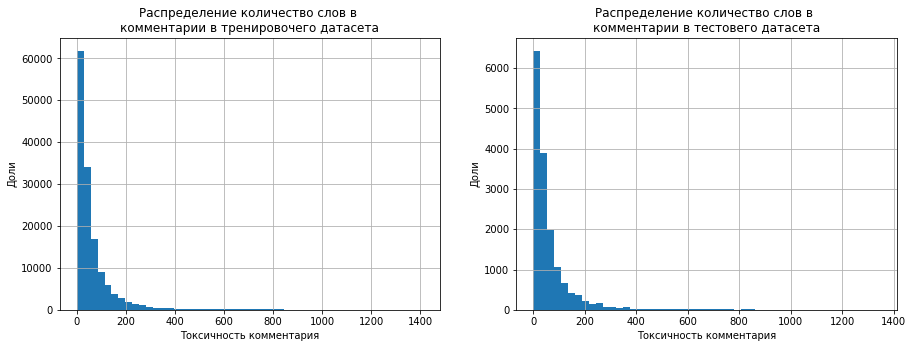

In [12]:
fig, axe = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

dataframes = [X_train_1['text'], X_test_1['text']]
name = ['тренировочего датасета', 'тестовего датасета']
                        
for index, dataframe in enumerate(dataframes):
                        
    dataframe.apply(lambda x : len(x.split())).hist(bins=50, ax=axe[index])
    axe[index].set_title(f'Распределение количество слов в \n'
                     f'комментарии в {name[index]}') 
    axe[index].set_xlabel('Токсичность комментария');
    axe[index].set_ylabel('Доли');

Мы видим, что большинство комментариев состоят менее чем из 150 слов. 

## Целевая переменная

### Анализ дисбаланса

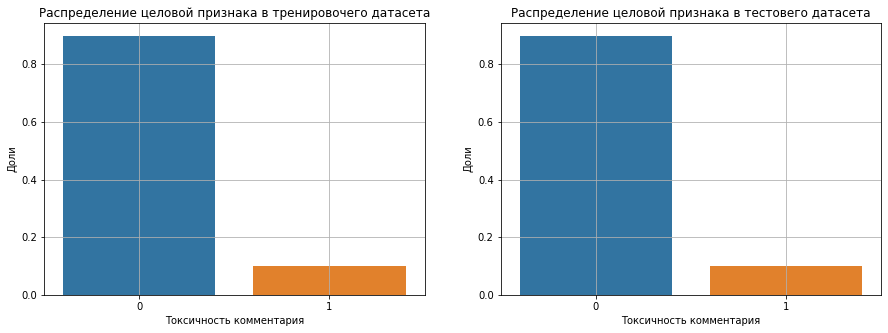

In [13]:
fig, axe = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

dataframes = [y_train, y_test]
name = ['тренировочего датасета', 'тестовего датасета']
                        
for index, dataframe in enumerate(dataframes):
                        
    df_target = dataframe.value_counts(normalize=True)                    
    sns.barplot(x=df_target.index, y=df_target, ax=axe[index]);
    axe[index].set_title(f'Распределение целовой признака в {name[index]}') 
    axe[index].set_xlabel('Токсичность комментария');
    axe[index].set_ylabel('Доли');
                        
    axe[index].grid();

На графике мы ясно видим, что у нас огромный дисбаланс целой признака, 90% — это объекты из основного класса (класс 0), а 1% — объекты из младшего класс класса (класс 1). 
Из-за этого значительного дисбаланса нашей метрикой для классификации будет «f1_score».

### Состав токсичных комментариев

In [14]:
df.query('toxic == 1')['text'].head(50)

6                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Если мы присмотримся к токсичным комментариям внимательнее, то заметим три вещи:
- использование ругательств: fuck, faggot, twat, moron ...
- множество слов написано с ошибками, сокращено или подвергнуто самоцензуре (чтобы избежать цензуры): «I dont care», «u» вместо you, «sh_tty» вместо «shitty»
- некоторые из них содержат много слов заглавными буквами, чтобы подчеркнуть их злость, например: «you are NOT an administrator. You DON't have the authority to tell me what do».

Мы будем использовать репрезентацию слов, чтобы увидеть, из каких слов в основном состоят комментарии.

### Представление слов для каждого класса

#### Нетоксичные комментарии

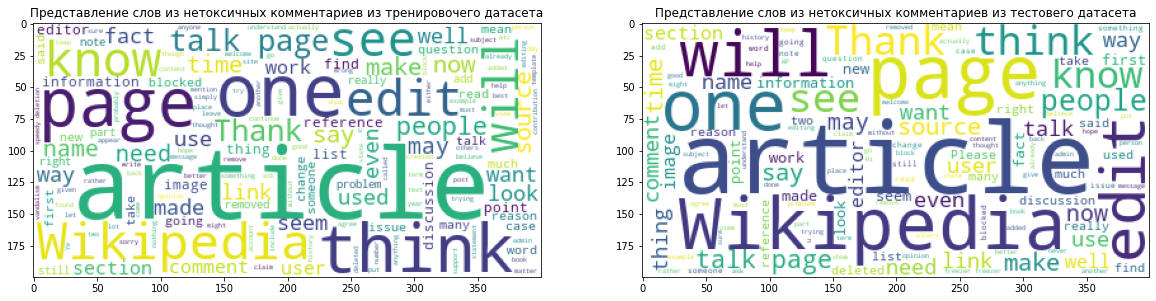

In [15]:
fig, axe = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Index of the objects from toxic comments
non_toxic_index = df.query('toxic==0').index

dataframes = [X_train_1, X_test_1]
name = ['тренировочего датасета', 'тестовего датасета']

for index,dataframe in enumerate(dataframes):
    intersec_non_toxic_index = set(dataframe.index).intersection(set(non_toxic_index))
    text = ' '.join(dataframe.loc[list(intersec_non_toxic_index),'text'])
    axe[index].imshow(WordCloud(background_color='white').generate(text))
    axe[index].set_title(f'Представление слов из нетоксичных комментариев из {name[index]}')

Как мы видим, в этих комментариях нет ни ругательств, ни расовых оскорблений. Если они и есть, то их определенно не так много.

#### Токсичные комментарии

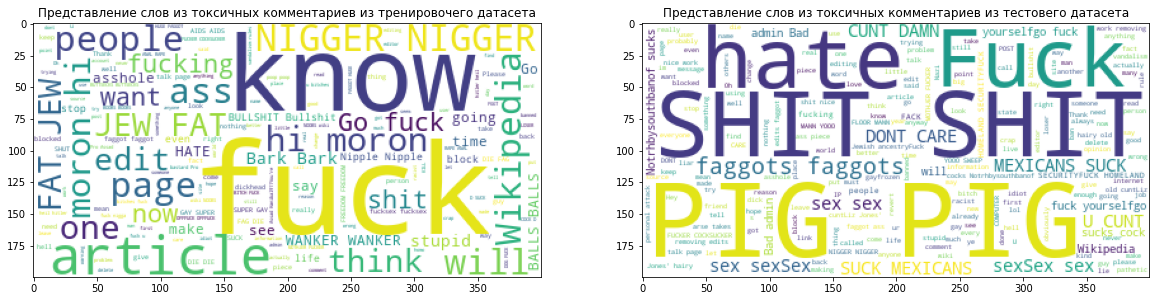

In [16]:
fig, axe = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Index of the objects from toxic comments
toxic_index = df.query('toxic==1').index

dataframes = [X_train_1, X_test_1]
name = ['тренировочего датасета', 'тестовего датасета']

for index,dataframe in enumerate(dataframes):
    intersec_toxic_index = set(dataframe.index).intersection(set(toxic_index))
    text = ' '.join(dataframe.loc[list(intersec_toxic_index),'text'])
    axe[index].imshow(WordCloud(background_color='white').generate(text))
    axe[index].set_title(f'Представление слов из токсичных комментариев из {name[index]}')

Мы ясно видим, что в токсичных комментариях много нецензурной лексики. Мы можем предположить, что, несмотря на дисбаланс, модели будет легко отличить, какие комментарии являются токсичными, а какие нет, поскольку большинство из последних содержат нецензурную лексику.

Давайте проверим, есть ли нетоксичные комментарии с нецензурной лексикой.

In [17]:
intersec_non_toxic_index = set(X_train_1.index).intersection(set(non_toxic_index))


In [18]:
X_train_1['f_word'] = X_train_1.loc[list(intersec_non_toxic_index),'text']\
                                                    .apply(lambda x: 1 if 'fuck' in x else 0)

In [19]:
X_train_1.query('f_word == 1').head()

text  \
131161                                                                                                                                                                                                                                                                          "\n\n Comment \n\nMy comments on Malleus' talk page were well beyond civil, even for a user talk page. They were a personal attack, and warranted serious sanction. \n\nFor the record, it was a simple spontaneous eruption of contempt mingled with rage. Some have muttered that I went to his page to harass him; that's not the case. I went to continue a discussion that had been interrupted by earlier admin action. Some are muttering that I went there to ""bait"" or ""poke"" him into a block. I appreciate the complement but my Machiavellian intelligence is non-existant. Obviously. \n\nI lost respect for Malleus when he said, ""You already succeeded in getting me blocked, so I can only presume that you're trying to repeat the trick."" I had made it clear that I had no intention of getting him blocked, he knew it, and yet regurgitated this populist slur. That's where he opened the door for my unmitigated opinion.\n\nBut my rant wasn't aimed at the dishonesty I perceived in that comment, that simply gave me permission to express a much deeper revulsion that's been building in me over the last few months with respect to this project. \n\nIt's a feeling, so I'm not sure I can make it clear. A kind of nauseous disgust. It's to do with how we deal with the hurt we may cause others, other editors, our subjects and our readers. I'm pleased to see the faltering steps being taken toward a more civil ethos here. Those who actually know me know that means a great deal to me. There is a long way to go. Pesky pointed out that finding the right form of words for what's required is difficult. I agree. That's the challenge. The right form of words will emerge if we discuss these questions enough.\n\nWith regard to respectful discourse between editors, Malleus has been addressing the real root of the civility problem here for years. Telling someone to fuck off, or calling them a cunt is obviously uncivil and an easy call for an admin. But the real evil here is not Malleus and me calling each other names, it's the sleazy aside from one editor to another, undermining the reputation of a third. One editor can bully or badger another for days or weeks without ever calling them a name, and it's their victim that cops a block when they respond accordingly. So I'm glad to see more admins taking civility seriously, but you're going to have to work on the sophistication of your approach.\n\nI'm disgusted by the way this project treats its readers with regard to controversial images. The bit that disgusts me is the mantra that ""we don't care if we offend our readers."" Seriously. That has been repeated ad nauseam during the Muhammad images debates and others. I can see no excuse for that attitude, and don't want to participate in an enterprise that has that attitude towards its readership.\n\nAnd finally, contempt for our subjects. I first noticed this on a BLP. A teenage girl and her boyfriend made a sex tape. Later, when she was a minor local celebrity, the tape was posted on the net, without her permission. It's there now; Google her name and ""sex tape"" and you got it. She's now won a TV competition, so is becoming better known.\n\nThe tape's existence has been mentioned a few times in the press, but not much, and usually the ""nudge, nudge, lucky bastard"" type of comment, but it doesn't seem to have affected her career or even her private life. An RfC asked ""Should we mention the tape?"" Policy-wise you can make a case for its inclusion, but it's borderline. What really disgusted me was the utter unconcern of many editors for the effect our inclusion of the factoid would have on the visibility of the tape, and the consequent effect this would have on the woman. I won't elabora

In [20]:
X_train_1['n_word'] = X_train_1.loc[list(intersec_non_toxic_index), 'text']\
                                                    .apply(lambda x: 1 if 'nigger' in x else 0)

In [21]:
X_train_1.query('n_word == 1').head()

,text,f_word,n_word
126723,""" and sounding similar to the English word nigger are used without the disparaging connotation the word holds in English. The French cognate , however, commonly used during the colonial period, is similarly considered offensive, whereas (literally, """"black"""") is the standard word, with the Anglicism black being a common slang term.\n\nInterestingly, in some places these words refer to people with an only slightly darker appearance than those native to Northern Europe, i.e. people who might be said to have a typically Mediterranean, Southern European/Eastern European appearance without any facial or hair-texture characteristics associated with black people. There are also socio-economic reasons behind this as southern Europeans but particularly eastern Europeans are stereotypically deemed more backwards and less well off than their northern European cousins.\n\nForms ultimately derived from Latin have been borrowed into various non-Romance languages, and may be used to refer to people without negative connotation; The Hungarian referred to black Africans without any negative connotations until the 1990s when its meaning changed under English influence. In Latvian, """"nēģeris"""" is still referred to black Africans without any derogatory meaning. The word nigger, typically with the same spelling and more or less similar pronunciation, also appears as a loanword in languages other than English and has the same racist connotations as the English word. In Nazi propaganda, the German compound niggerjazz was used as a derogatory term for jazz music, which Nazi ideology held was a degenerate form of music. In Yiddish, """"shvartzer"""", meaning 'black' is considered offensive while """"neger"""" is the standard word.\n\nNon-human uses\nIn the past, nigger was sometimes used as a synonym for """"defect"""", deriving from the phrase """"nigger in the woodpile"""", which originally referred to escaping slaves hiding among woodpiles being transported on trains. It came to mean some unseen problem.Definition of nigger in the woodpile For example, the May 1886 issue of Scientific American, page 308 said, """"The consequence of neglect might be that what the workmen call ‘a nigger’ would get into the armature, and burn it so as to destroy its service.""""\n\nThe term nigger was used in lumber mills until the mid-point of the 20th century. It refers to a device that turns a log while it is being stripped of its bark. This may be an off-hand reference to the prejudicial use of the word, as until the machine was invented, this was considered a job too dangerous for anyone other than a black man.\n\nLiterary uses\nNigger has a long history of controversy in literature. Carl Van Vechten, a white photographer and writer famous as a supporter of the Harlem Renaissance, provoked debate and some protest from the African American community by titling his 1926 novel Nigger Heaven. The controversy centered on the use of the word in the title and fueled the sales of the hit novel. Of the controversy, Langston Hughes wrote:\n\nThe poem Little Topsy's SongLittle Topsy's Song: Sung by the Hutchinson family A modern recording. Music by Asa B. Hutchinson(1823–1884), Boston: Oliver Ditson, 1853Little Topsy's Song: Text and Sources Music by Asa Hutchinson and also by Henry Russell (1801–1900) written in about 1845 by Eliza Cook has the first stanza\n'Topsy neber was born, / Neber had a moder; / Specks I growed a nigger brat, / Just like any oder.\n\nThe famous controversy over Mark Twain's novel Adventures of Huckleberry Finn (1885), a classic frequently taught in American schools, revolves largely around the novel's 215 uses of the word, often referring to Jim, Huck's raft mate.{{cite web\n| title= Adventures",0.0,1.0
52514,"""\n\n""""Unquestionably"""" racist? It's very questionable. Unquestionably questionable. It looks like he just didn't want someone to take his use of the word """"nigger"""" out of context. It looks like 

Мы видим, что даже в нетоксичных комментариях часто встречаются слова «fuck» или «nigger». Обычно эти слова пишутся в скобках, потому что они считаются кавычками. Мы также видим, что «fuck up» может не считаться ругательством.

In [22]:
X_train_1 = X_train.copy()

# Пользовательская функция

Я выполнил множество различных операций с набором данных, ниже приведены мои наблюдения:

- <b> Стоп-слова </b> : Я пробовал полностью их удалить или использовать атрибут 'stopwords' из TfidfVectorizer. В обоих случаях наша метрика ухудшилась. Это можно понять, потому что в стоп-словах у нас есть слова типа 'don't', которые могут быть полезны для понимания тона комментария. Например, 'like' становится семантически ближе к слову 'hate', если мы используем 'don't' с ним.

- <b> TweetTokenizer вместо word_tokenize </b> : С моей точки зрения я бы предпочел использовать tweet.tokenizer(), который режет слова лучше, чем word_tokenize()

- <b> Стемминга вместо лемматизации </b> : Поскольку у нас огромный датафрейм, лемматизация занимала много времени. Я выбрал использование стемминга, потому что он быстрее. Обычно последние считаются хуже, чем лемматизация. Однако, поскольку у нас много объектов для обучения, я думаю, что использование стемминга вместо лемматизации не будет иметь большого значения.

- <b> Сохранение заглавных букв для слов, написанных заглавными буквами </b> : Как мы видели, многие токсичные комментарии были написаны заглавными буквами. Это может помочь отличить токсичные комментарии от нетоксичных. Однако мы перевели в нижний регистр слова, которые начинались с заглавной буквы, а слова которие написаны c буквами в верхнем регистре мы соханяли так с помощю пользовательских функций stemming.

- <b> Сохранение ' </b> : мы также сохранили ', потому что мы видели, что иногда ругательства цитировались в нетоксичных комментариях.

- <b> Функция для разделения повторяющегося узора </b> : Я создал функцию для уменьшения размера длинных слов, некоторые из которых представляли собой просто слова, написанные друг за другом, например «CRAPCRAPCRAP».

- <b> Функция штрафования за использование нецензурной лексики </b> : Я также создал функцию для штрафования за использование ругательств. Мы могли бы выдвинуть гипотезу, что нетоксичные комментарии не содержат ругательств. То, что заставляет нас распознавать токсичные комментарии, — это использование ругательств. После анализа результатов я увидел, что некоторые комментарии были классифицированы как нетоксичные, даже если они содержали одно ругательство. Почему эти комментарии не считались токсичными? Вероятно, потому, что в очень многих комментариях было много ругательств. Затем я создал функцию для увеличения количества некоторых из этих ругательств, чтобы комментарии считались токсичными. Это своего рода добавление некоторого веса для алгоритма TD-IDF. Использование этой функции действительно увеличило наш счет f1.

In [23]:
# Функция для разделения повторяющегося узора
def separating_repeating_patterns(t):
    res_fndll = re.findall(r'(\w+?)(\1{2,})', t)
    for tup in res_fndll:
        strg = tup[1]
        pttrn = tup[0]
        if len(pttrn) == 1:
            new_str = pttrn
            t = t.replace(tup[0]+tup[1], new_str)
        else:
            fact = int(len(strg)/len(pttrn))
            new_str = (pttrn+' ')*(fact + 1)
            t = t.replace(tup[0]+tup[1], new_str)
    return t

In [24]:
# Настройл stemmer, чтобы оставить только слова в верхнем регистре
def stemming(word):
    sbs = SnowballStemmer(language='english')
    if word.isupper():
        word = sbs.stem(word).upper()
    else:
        word = sbs.stem(word)
    return word

In [25]:
# Функция штрафования за использование нецензурной лексики
def penalty_swear_words(t):
    swear_words = ['fuck', 'nigg', 'faggot', 'wanker', 'cunt', 'shit']
    
    for word in swear_words:

        res = re.findall(rf"(\w+{word})|({word}\w+)|({word})", t, re.IGNORECASE)

        if len(res) != 0:
            for word in res[0]:
                if len(word) != 0:
                    t = t + ' ' + (str(word) + ' ')*5
    return t

In [26]:
# Создание функции трансформатора
def data_prep(text):
    
    # Очистка текста
    clean_text = re.sub(r'(http:\/\/www|www)\.[\w]+.[\w]{,3}', ' ', text) # Удаление адресы веб-сайта
    clean_text = re.sub(r'[^a-zA-Z\']', ' ', clean_text) # Удаляем все цифры и знаки препинания, кроме '
    clean_text = re.sub(r'(\w)\'(\w)', '\\1\\2', clean_text) # Удаляем ' между двух буква

    clean_text = separating_repeating_patterns(clean_text) # Separating by a space the repeating patterns
    clean_text = re.sub(r'(\w{45,})', ' ', clean_text) # вырезание длинного текста самое длинное слово в 
                                                        # английском языке состоит из 45 букв
    clean_text = penalty_swear_words(clean_text) # Функция наказания за использование нецензурной лексики
    clean_text = re.sub(r'(f.ck)|(\sf\s)', 'fuck', clean_text, re.IGNORECASE)# Исправление опечаток или цензуры
                                                                             # самое популярное ругательство
  
    # Токенизация
    tweet_tokenizer = TweetTokenizer()
    text_tokenized = tweet_tokenizer.tokenize(clean_text)

    # Stemming
    return " ".join([stemming(word) for word in text_tokenized])

In [27]:
# Подготовка нашего обучающего набора данных
tqdm.pandas(desc='Progression...')
X_train_1['stemm_text'] = X_train_1['text'].progress_apply(lambda x: data_prep(x))

Progression...: 100%|██████████| 143362/143362 [03:13<00:00, 739.55it/s]


In [28]:
X_train_1.head()

,text,stemm_text
22585,"""\n\nPlease stop. If you continue to vandalize pages, as you did to Saint-Victor, you will be blocked from editing Wikipedia. A link to the edit I have reverted can be found here: link. If you believe this edit should not have been reverted, please contact me. (| '''UlTiMuS''' ( • T • C | • E ) """,pleas stop if you continu to vandal page as you did to saint victor you will be block from edit wikipedia A link to the edit I have revert can be found here link if you believ this edit should not have been revert pleas contact me ' ' ' ultimus ' ' ' T C E
150346,"""\n\n Your Chanology """"nonviolence"""" comment \n\nYou say that one of my edits to the Chanology page was unnecessary due to it being repeated later on and their partyvan page not being a reliable source. IF the partyvan page cannot be viewed as reliable in that aspect, what about the code of conduct video posted on youtube by the same member who posted the call to action video. It clearly states a nonviolent approach in their methods. This is worth mentioning in the context of """"guerrilla tactics"""" because it makes a big difference to the reader. Just my thoughts. """,your chanolog nonviol comment you say that one of my edit to the chanolog page was unnecessari due to it be repeat later on and their partyvan page not be a reliabl sourc IF the partyvan page cannot be view as reliabl in that aspect what about the code of conduct video post on youtub by the same member who post the call to action video it clear state a nonviol approach in their method this is worth mention in the context of guerrilla tactic becaus it make a big differ to the reader just my thought
16991,", All the changes in which the Species Abbreviation template was removed are in the pipeline to be reversed - Wikipedia talk:WikiProject Disambiguation#Species abbreviations. Thanks,",all the chang in which the speci abbrevi templat was remov are in the pipelin to be revers wikipedia talk wikiproject disambigu speci abbrevi thank
51659,"""::: """"Red-headed boys blonde girls tease tease brunette girls.""""\n\n It's not very pretty, but it works without the """"whom"""" (whom blonde girls tease). Then replace all hair colors to Buffalo and all boys and girls to buffalo, and you end up with the sentence """"Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo."""" Quod erat demonstrandum. Tony Sidaway \n\n""",red head boy blond girl teas teas brunett girl it not veri pretti but it work without the whom whom blond girl teas then replac all hair color to buffalo and all boy and girl to buffalo and you end up with the sentenc buffalo buffalo buffalo buffalo buffalo buffalo buffalo buffalo quod erat demonstrandum toni sidaway
51916,Britain in need \nHelp stop islam in Britain vote BNP,britain in need help stop islam in britain vote BNP


Мы видим, что наш обучающий набор данных теперь готов к векторизации.

In [29]:
X_train_1 = X_train_1.drop('text', axis=1)

In [30]:
X_train_1.head()

,stemm_text
22585,pleas stop if you continu to vandal page as you did to saint victor you will be block from edit wikipedia A link to the edit I have revert can be found here link if you believ this edit should not have been revert pleas contact me ' ' ' ultimus ' ' ' T C E
150346,your chanolog nonviol comment you say that one of my edit to the chanolog page was unnecessari due to it be repeat later on and their partyvan page not be a reliabl sourc IF the partyvan page cannot be view as reliabl in that aspect what about the code of conduct video post on youtub by the same member who post the call to action video it clear state a nonviol approach in their method this is worth mention in the context of guerrilla tactic becaus it make a big differ to the reader just my thought
16991,all the chang in which the speci abbrevi templat was remov are in the pipelin to be revers wikipedia talk wikiproject disambigu speci abbrevi thank
51659,red head boy blond girl teas teas brunett girl it not veri pretti but it work without the whom whom blond girl teas then replac all hair color to buffalo and all boy and girl to buffalo and you end up with the sentenc buffalo buffalo buffalo buffalo buffalo buffalo buffalo buffalo quod erat demonstrandum toni sidaway
51916,britain in need help stop islam in britain vote BNP


# Обучение

## Кросс-Валидация

Мы обучаем 3 модели для кросс-валидаци:
- LogisticRegression()
- SGDClassifier()
- RandomForestClassifier()

In [31]:
estimator_pipe = Pipeline([
    ("vect", TfidfVectorizer(lowercase=False)),
    ('models', LogisticRegression(max_iter=1500, class_weight = 'balanced', random_state=RANDOM_STATE))
])

# создаём итоговый пайплайн: подготовка данных и модель
param_grid = [    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
                            solver='liblinear',
                            max_iter=200,
                            class_weight = 'balanced',
                            random_state=RANDOM_STATE,
                            
        )],
        'models__C': [1, 10, 100],
        'models__penalty': ['l2', 'l1'],
        'vect__ngram_range': [(1, 1), (1, 2)]  # unigrams or bigrams
      },
    # словарь для модели SGDClassifier()
    {
        'models':[SGDClassifier(
                      loss = 'hinge',
                      class_weight = 'balanced',
                      random_state=RANDOM_STATE
                    
        )],
        'models__alpha': [1e-06, 1e-05],  
        'models__penalty': ['l2', 'l1'],
        'vect__ngram_range': [(1, 1), (1, 2)]#, (1, 3)],  # unigrams or bigrams
        
       },
   # словарь для модели RandomForestClassifier()
     {
        'models':[RandomForestClassifier(
                        class_weight = 'balanced',
                        random_state=RANDOM_STATE
        )],
        'models__n_estimators': [48, 64],
        'models__max_features': [10, 14],
        'vect__ngram_range': ((1, 1), (1, 2))  # unigrams or bigrams
      }
  ]

In [32]:
randomized_search = RandomizedSearchCV(
    estimator_pipe, 
    param_grid, 
    cv=3,
    scoring='f1',
    random_state=RANDOM_STATE,
    error_score="raise",
    verbose=3,
    n_jobs=-1
)
randomized_search.fit(X_train_1['stemm_text'], y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END models=LogisticRegression(class_weight='balanced', max_iter=200, random_state=42,
                   solver='liblinear'), models__C=100, models__penalty=l2, vect__ngram_range=(1, 2); total time= 1.2min
[CV 2/3] END models=LogisticRegression(class_weight='balanced', max_iter=200, random_state=42,
                   solver='liblinear'), models__C=100, models__penalty=l2, vect__ngram_range=(1, 2); total time= 1.2min
[CV 3/3] END models=LogisticRegression(class_weight='balanced', max_iter=200, random_state=42,
                   solver='liblinear'), models__C=100, models__penalty=l2, vect__ngram_range=(1, 2); total time= 1.2min
[CV 1/3] END models=RandomForestClassifier(class_weight='balanced', random_state=42), models__max_features=14, models__n_estimators=48, vect__ngram_range=(1, 2); total time=25.3min
[CV 2/3] END models=RandomForestClassifier(class_weight='balanced', random_state=42), models__max_features=14, mo

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(lowercase=False)),
                                             ('models',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1500,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(C=100,
                                                                       class_weight='balanced',
                                                                       max_iter=200,
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                     

In [33]:
# Итог гиперпараметр тюнинг
report_randomized_search = pd.DataFrame(randomized_search.cv_results_)
pd.set_option('display.max_colwidth', None)
report_randomized_search\
.sort_values('rank_test_score', ascending=True)[['params',\
                                                 'mean_fit_time', 'mean_score_time',\
                                                 'mean_test_score', 'rank_test_score']].head(10)

,params,mean_fit_time,mean_score_time,mean_test_score,rank_test_score
0,"{'vect__ngram_range': (1, 2), 'models__penalty': 'l2', 'models__C': 100, 'models': LogisticRegression(C=100, class_weight='balanced', max_iter=200, random_state=42, solver='liblinear')}",65.276104,6.857854,0.798905,1
6,"{'vect__ngram_range': (1, 2), 'models__penalty': 'l2', 'models__alpha': 1e-05, 'models': SGDClassifier(class_weight='balanced', random_state=42)}",21.289641,7.466762,0.794857,2
9,"{'vect__ngram_range': (1, 2), 'models__penalty': 'l2', 'models__alpha': 1e-06, 'models': SGDClassifier(class_weight='balanced', random_state=42)}",21.029900,7.443798,0.785731,3
8,"{'vect__ngram_range': (1, 2), 'models__penalty': 'l1', 'models__C': 100, 'models': LogisticRegression(C=100, class_weight='balanced', max_iter=200, random_state=42, solver='liblinear')}",37.058959,7.323414,0.779404,4
2,"{'vect__ngram_range': (1, 1), 'models__penalty': 'l2', 'models__C': 100, 'models': LogisticRegression(C=100, class_weight='balanced', max_iter=200, random_state=42, solver='liblinear')}",49.811862,2.180206,0.759254,5
4,"{'vect__ngram_range': (1, 1), 'models__penalty': 'l2', 'models__C': 1, 'models': LogisticRegression(C=100, class_weight='balanced', max_iter=200, random_state=42, solver='liblinear')}",21.209613,2.105849,0.750479,6
5,"{'vect__ngram_range': (1, 1), 'models__penalty': 'l2', 'models__alpha': 1e-06, 'models': SGDClassifier(class_weight='balanced', random_state=42)}",5.727163,2.137885,0.749000,7
7,"{'vect__ngram_range': (1, 1), 'models__n_estimators': 64, 'models__max_features': 10, 'models': RandomForestClassifier(class_weight='balanced', random_state=42)}",241.210250,11.877760,0.511325,8
1,"{'vect__ngram_range': (1, 2), 'models__n_estimators': 48, 'models__max_features': 14, 'models': RandomForestClassifier(class_weight='balanced', random_state=42)}",1475.589349,72.933056,0.465231,9
3,"{'vect__ngram_range': (1, 2), 'models__n_estimators': 48, 'models__max_features': 10, 'models': RandomForestClassifier(class_weight='balanced', random_state=42)}",1446.978430,67.377967,0.463703,10


## Векторизация слов

In [34]:
# Создание нашего объекта TF-IDF
count_tf_idf = TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

In [35]:
# Fit and transform наш тренировочной датасет
X_train_tf_idf = count_tf_idf.fit_transform(X_train_1['stemm_text'])

In [36]:
# Отображение количества функций
X_train_tf_idf.shape

(143362, 1890951)

## Самая лучая модель

In [37]:
model = randomized_search.best_estimator_
model

Pipeline(steps=[('vect', TfidfVectorizer(lowercase=False, ngram_range=(1, 2))),
                ('models',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=200, random_state=42,
                                    solver='liblinear'))])

Наша самая лучая модель - LogisticRegression(class_weight='balanced', max_iter=200, random_state=42, C=100, penalty='l2', solver='liblinear').

# Прогнозы

In [39]:
# Подготовка нашего признак 'text' для тестового набора данных
X_test_1['stemm_text'] = X_test_1['text'].apply(lambda x: data_prep(x))

In [40]:
X_test_1 = X_test_1.drop('text', axis=1)

In [41]:
# Векторизация слов
X_test_tf_idf = count_tf_idf.transform(X_test_1['stemm_text'])

f1_score: 0.8185547491322184
Метрика Recall на тестовой выборке: 0.8011117974058061
Метрика Precision на тестовой выборке: 0.8367741935483871


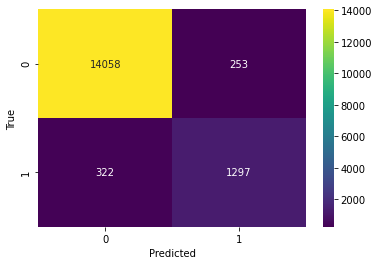

In [87]:
# Рассчитываем прогноз на тестовых данных
y_pred = model.predict(X_test_1['stemm_text'])

y_proba = model.predict_proba(X_test) 

y_proba_one = y_proba[:, 1]

print('f1_score:', f1_score(y_test, y_pred))

print(f'Метрика Recall на тестовой выборке: {recall_score(y_test, y_pred)}')
print(f'Метрика Precision на тестовой выборке: {precision_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.ylabel('True')
plt.xlabel('Predicted'); 

Мы видим, что наша модель немного недообучалась. 

Мы успешно получили метрику f1 более 75 (82%).

Истинно отрицательный = 14058, комментарии, оцененные как нетоксичные и которые действительно были нетоксичными.

Истинно положительный = 1297, комментарии, оцененные как токсичные, и которые действительно были токсичными.

Ошибка первого рода = 253, комментарии, оцененные как токсичные, и которые не были токсичными.

Ошибка второго рода = 322, комментарии, оцененные как нетоксичные, и которые не были нетоксичными.

# Улучшение модели

Сначала нам необходимо проанализировать, почему токсичные комментарии были отнесены к категории нетоксичных.

In [88]:
data = pd.DataFrame(zip(y_test, y_pred), index=y_test.index)
data.columns = ['y_test', 'y_pred']
data.head()

,y_test,y_pred
150853,0,0
30575,0,0
35302,1,1
156655,0,0
97121,0,0


In [89]:
# Индекс ложноотрицательного результата
index_false_negative = data.query('y_test == 1 and y_pred == 0').index
# Проверяем, что мы получили их все
len(index_false_negative)

322

In [90]:
for i in X_test_1.loc[index_false_negative, 'stemm_text']:
    print(i)

your wrong IAR appli to admin and regular editor alik you have provid no evid of that as I said I have the fact and you guy just have bullshit what is a regular editor I am not a regular editor I am an occasion editor the ignor all rule rule doe not mean there can be one set of rule except for you and anoth set of rule except for me we can agre on an except to the rule but the except must appli equal to both of us for exampl we could agre that it is OK here to break the wikipedia rule against use person blog as sourc but that would mean that link to my blog must be allow here and could not be exclud by arbitrari discriminatori distinct between crappi person blog and reput person blog as fathead ed brayton would say you are full of batshit wingnutteri bullshit bullshit bullshit bullshit bullshit
take your own advic AND STOP HARASS ME
nope kill by hunger is not good english while starv someon to death is PERFECT translat for
and to suggest that is flabbergast arrog
and as fulli expect ye

Мы видим, что наша модель неправильно классифицировала некоторые комментарии, потому что:
- некоторые слова были написаны неправильно, например 'FVCK'
- расистское оскорбление: 'paki one of the most ugliest individu of this EARTH'
- жестокая лексика : 'you and your famili shall burn'
- слова, относящиеся к эпизодам нашей истории имеющое негативный оттенок: 'wow just delet my comment great job on the free speech there adolf'

Одним из способов улучшения модели было бы создание функции для исправления всех ругательств, а также, возможно, создание токсичного лексического словаря. 

# Выводы

В этом проекте нам пришлось выполнить задачу бинарной классификации, обучив модель, чтобы иметь возможность предсказывать, являются ли комментарии из интернета токсичными или нет.  В наше цель - 'toxic' - высокий дисбаланс (90% -10%).

Для этого мы очистили наш набор данных, разместили длинные повторяющиеся шаблоны, выполнили простую работу с текстом, например, удалили знаки препинания, токенизировали наши комментарии перед их стеммингом.
После стемминга мы векторизовали комментарии с помощью метода TfidfVectorizer().

Отсюда мы получили матрицу признаков, которую мы обучили 3 различных моделей с помощю кросс-валидации:
- LogisticRegression()
- SGDClassifier()
- RandomForestClassifier()

После перекрестной проверки мы поняли, что наша лучшая модель — LogisticRegression(class_weight='balanced', max_iter=200, random_state=42, C=100, penalty='l2', solver='liblinear').

Из нашего тестового набора данных мы получили оценку f1 82%, что является хорошим результатом, учитывая также несбалансированность набора данных.

Одним из способов улучшить наш результат может стать более эффективная работа по выделению и проверке правописания ругательных слов, а также создание лексического словаря, содержащего все возможные «токсичные» слова.